# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [11]:

filtroParaElSubsetDeDatos = ['La Pampa', 'Córdoba', 'Mendoza', 'San Luis', 'San Juan', 'Santa Fe', 'Santiago Del Estero',\
                            'Buenos Aires Interior']

In [12]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21668 entries, 9 to 109281
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              21668 non-null  object 
 1   place_name                 21668 non-null  object 
 2   price                      21668 non-null  float64
 3   surface_covered_in_m2      21668 non-null  float64
 4   surface_not_covered_in_m2  21668 non-null  float64
 5   price_usd_per_m2           21668 non-null  float64
 6   rooms                      21668 non-null  float64
 7   lat_mediaPorZona           21668 non-null  float64
 8   lon_mediaPorZona           21668 non-null  float64
 9   pileta                     21668 non-null  int64  
 10  cochera                    21668 non-null  int64  
 11  balcon                     21668 non-null  int64  
 12  terraza                    21668 non-null  int64  
 13  parrilla              

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

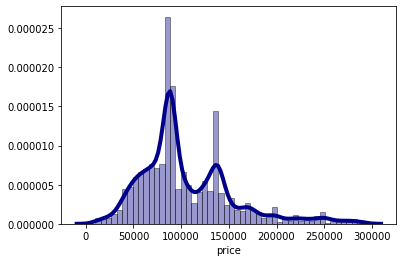

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


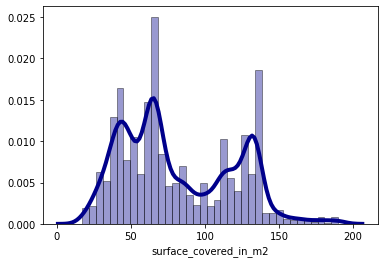

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

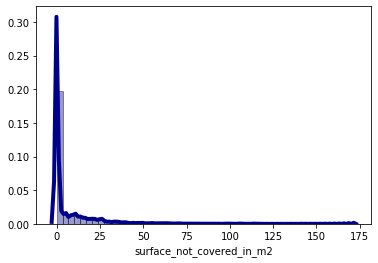

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

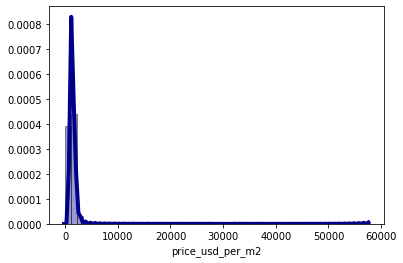

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

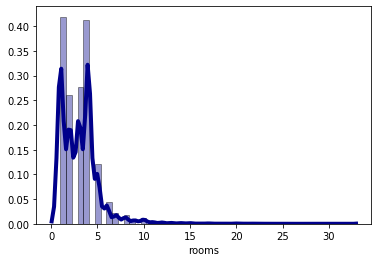

In [17]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [18]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000
mean,104780.929355,81.117317,7.618144,1372.529650,3.128623,-32.505063,-62.660737,0.107163,0.344333,0.212710,0.206849,0.097379
std,48691.229202,37.428718,16.207742,1950.886086,2.191785,1.638249,2.143083,0.309327,0.475161,0.409234,0.405055,0.296479
min,10000.000000,17.000000,0.000000,0.600000,1.000000,-40.777585,-69.252984,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74030.450000,50.000000,0.000000,872.125421,1.000000,-32.947316,-64.203046,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88876.824330,67.000000,0.000000,1228.004507,3.000000,-31.678706,-64.203046,0.000000,0.000000,0.000000,0.000000,0.000000
75%,135000.000000,116.000000,9.000000,1570.085648,4.000000,-31.420413,-60.661852,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,170.000000,57382.080000,32.000000,-27.493565,-56.715117,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 3000)

In [20]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 8)

In [21]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18719 entries, 0 to 18718
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              18719 non-null  object 
 1   place_name                 18719 non-null  object 
 2   price                      18719 non-null  float64
 3   surface_covered_in_m2      18719 non-null  float64
 4   surface_not_covered_in_m2  18719 non-null  float64
 5   price_usd_per_m2           18719 non-null  float64
 6   rooms                      18719 non-null  float64
 7   lat_mediaPorZona           18719 non-null  float64
 8   lon_mediaPorZona           18719 non-null  float64
 9   pileta                     18719 non-null  int64  
 10  cochera                    18719 non-null  int64  
 11  balcon                     18719 non-null  int64  
 12  terraza                    18719 non-null  int64  
 13  parrilla                   18719 non-null  int

# Analizamos las variables categóricas

córdoba                  7354
rosario                  6072
santa fe                  532
punilla                   517
bahía blanca              385
                         ... 
la colina golf & polo       1
chacras de coria            1
pérez                       1
las tapias                  1
casa grande                 1
Name: place_name, Length: 230, dtype: int64


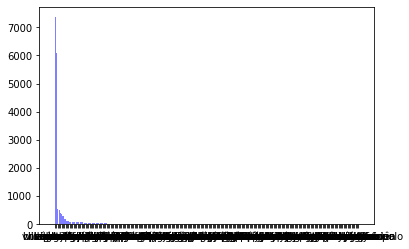

apartment    11828
house         5825
store          617
PH             449
Name: property_type, dtype: int64


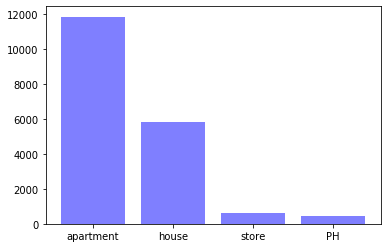

In [22]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [23]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [24]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa nueva,place_name_villa parque santa ana,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago,place_name_villa ventana,place_name_zárate,property_type_apartment,property_type_house,property_type_store
0,house,córdoba,70000.000000,134.014337,0.0,522.332174,4.0,-31.420413,-64.203046,0,...,0,0,0,0,0,0,0,0,1,0
1,house,villa giardino,142500.000000,148.000000,0.0,962.837838,5.0,-31.051430,-64.497877,0,...,0,0,0,0,0,0,0,0,1,0
2,apartment,córdoba,30846.020000,50.000000,0.0,616.920400,3.0,-31.420413,-64.203046,0,...,0,0,0,0,0,0,0,1,0,0
3,house,malagueño,70104.590000,75.000000,0.0,934.727867,4.0,-31.458349,-64.377134,0,...,0,0,0,0,0,0,0,0,1,0
4,apartment,villa carlos paz,86776.236614,115.000000,0.0,754.575971,4.0,-31.436755,-64.497400,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [25]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_adolfo alsina,place_name_agua de oro,place_name_alta gracia,place_name_alto los cardales,place_name_alvear,place_name_anisacate,place_name_arequito,place_name_arocena,place_name_arroyo leyes,...,place_name_villa los aromos,place_name_villa maría,place_name_villa mercedes,place_name_villa nueva,place_name_villa parque santa ana,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago,place_name_villa ventana,place_name_zárate
0,córdoba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,villa giardino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,malagueño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,villa carlos paz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,rosario,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17430,los cocos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17722,la cumbrecita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17746,indio cuá country club,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18144,lobería,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [26]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,house,0,1,0
2,apartment,1,0,0
15,PH,0,0,0
16,store,0,0,1


# Generamos el objeto para el K Fold

In [27]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [28]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa nueva,place_name_villa parque santa ana,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago,place_name_villa ventana,place_name_zárate,property_type_apartment,property_type_house,property_type_store
0,134.014337,0.0,522.332174,4.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,148.000000,0.0,962.837838,5.0,-31.051430,-64.497877,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,50.000000,0.0,616.920400,3.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,75.000000,0.0,934.727867,4.0,-31.458349,-64.377134,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,115.000000,0.0,754.575971,4.0,-31.436755,-64.497400,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18714,52.000000,0.0,1619.955385,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18715,50.000000,0.0,1680.266800,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18716,52.000000,0.0,1625.348077,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18717,50.000000,0.0,1684.753600,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Generamos un modelo con Regresion Lineal

In [29]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [30]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [31]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-3.96388609e+25 -6.14816641e+27 -2.53299745e+27 -4.12316742e+26
 -2.25625505e+28]



Intercept: 
1323.865468905805



Coeficientes: 
[-2.26227331e+02 -1.38134281e+02 -1.98255537e-01  5.56952429e+13
  4.65943949e+14  3.33768275e+01  1.19091066e+01  2.72714977e+01
  1.99810864e+00 -1.10129858e+00 -5.54548065e+12 -2.86771805e+12
 -3.25797229e+12 -1.36175856e+13 -7.03212475e+12 -2.23035536e+12
 -5.69302634e+11 -1.21268029e+13 -7.77376831e+12 -7.31935990e+12
 -2.97437223e+12 -2.79367657e+13 -1.82312350e+13 -5.18649220e+13
 -8.65718402e+13 -4.20591537e+12 -7.64893286e+12 -1.52889499e+13
 -5.27715416e+12 -8.74513490e+12 -4.81167725e+13 -1.80978334e+12
 -3.55165096e+13  6.75269650e+12 -3.73581300e+12 -3.63247582e+13
 -1.06880067e+13 -2.37812048e+12 -9.41411252e+12 -2.64024694e+13
 -1.17096705e+13 -1.36534163e+13 -8.97520540e+12 -9.16780903e+12
 -2.16127155e+13  2.16221734e+12 -1.03568856e+12 -4.82869487e+13
 -1.20118821e+13  7.00349873e+12 -6.99905758e+13 -1

In [32]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
13178,1352.017143,1492.151276,-140.134133
11302,1032.875485,1052.103869,-19.228384
1434,1245.704615,1445.026276,-199.321660
6366,1428.215887,1388.338776,39.877111
17412,669.584181,1057.353869,-387.769688
...,...,...,...
12239,1539.551765,1545.088776,-5.537011
17261,825.792623,1422.401276,-596.608653
15530,1336.672090,1370.713776,-34.041686
18026,1096.435875,1272.026276,-175.590401


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [33]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [34]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: [0.27125053 0.27097108 0.26676246 0.28822112 0.28168984]
Alpha Ridge CV: 10.0
Coeficientes:  [-2.25562924e+02 -1.38242642e+02 -3.82610529e+00  9.47109587e-01
  7.03028645e+01  3.14456334e+01  1.21935050e+01  2.67258985e+01
  2.84726106e+00 -4.20303159e+00  1.54019528e+01  3.88613770e+00
  6.88576223e+00  3.91461779e+00 -3.30600694e+00  7.87967513e+00
  5.80244855e+00 -8.95664906e-01 -6.96785938e-01 -1.97187769e-01
  8.72033161e+00 -3.44308691e+00  1.42581496e+00  1.91784801e+01
 -1.20925345e+00  5.94471153e-01 -4.06213412e-02  7.69652505e+00
 -2.81908244e+00 -7.65432487e-01 -6.30659672e+00 -3.15338996e+00
 -1.05213317e+01  1.43408177e+01  2.56910471e+01  8.60750505e+00
  3.29735430e+00  3.84327587e+00  3.82637607e+00 -6.48064252e+00
  4.55923153e-01  9.87232986e+00  4.74970718e+00  1.21391265e+00
  1.78789965e+01  0.00000000e+00  8.45294027e+00  2.99791947e+00
 -1.25827077e+00  8.87469791e+00 -4.17857499e+00  8.38550918e+00
 -5.95198124e+00  2.39730607e+00  1.01021898e+

In [35]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
13178,1352.017143,1496.428830,-144.411687
11302,1032.875485,1055.963382,-23.087898
1434,1245.704615,1450.353199,-204.648583
6366,1428.215887,1385.398636,42.817250
17412,669.584181,1070.086151,-400.501970
...,...,...,...
9359,1037.808076,1285.673010,-247.864935
5179,1304.027214,1211.068638,92.958576
1670,1342.203826,1315.861674,26.342152
14691,1570.342857,1629.813502,-59.470645


# Generamos el modelo para Lasso Cross Validation

In [36]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1323.824175547926



Coeficientes: 



[-2.21733872e+02 -1.34593872e+02 -2.96775983e+00 -6.00767261e+00
  0.00000000e+00  3.08824689e+01  9.80103869e+00  2.47368335e+01
  9.85223895e-01 -1.09950137e-01  1.05076287e+01  0.00000000e+00
  1.08953105e+00  2.09028917e+00 -2.06876557e+00  3.23044955e+00
  2.50793969e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  4.56676718e+00 -1.20983361e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  5.42339874e+00
 -2.03848295e+00 -0.00000000e+00 -2.95662927e+00 -3.84919259e+00
 -8.14591462e+00  9.79678924e+00  1.25006499e+01  6.86271285e+00
  1.69311392e+00  0.00000000e+00  1.87232149e+00 -6.34985084e+00
  0.00000000e+00  8.03344670e+00  1.67601795e+00  0.00000000e+00
  1.55947562e+01  0.00000000e+00  5.11530421e+00 -0.00000000e+00
 -0.00000000e+00  4.38968236e+00 -7.98450203e-01  6.29306562e+00
 -4.83335648e+00 -0.00000000e+00 -0.00000000e+00 -4.05846668e-01
  0.00000000e+00  5.42263991e+00 

In [37]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
13178,1352.017143,1494.024762,-142.007619
11302,1032.875485,1058.020907,-25.145422
1434,1245.704615,1452.691767,-206.987152
6366,1428.215887,1380.403429,47.812457
17412,669.584181,1066.020773,-396.436592
...,...,...,...
9359,1037.808076,1216.857136,-179.049060
5179,1304.027214,1197.377096,106.650118
1670,1342.203826,1322.112518,20.091308
14691,1570.342857,1626.693614,-56.350757


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [38]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-3.96388609e+25 -6.14816641e+27 -2.53299745e+27 -4.12316742e+26
 -2.25625505e+28]
Score Train Ridge:  [0.27125053 0.27097108 0.26676246 0.28822112 0.28168984]
Score Train Lasso:  [0.2724086  0.26953664 0.27761044 0.2902336  0.2850157 ]


### Visualizamos los errores cuadraticos medios

In [39]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 69371865243263.14
Train RMSE RidgeCV: 386.54381311253377
Train RMSE Lasso: 386.6562511239888


In [40]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: -2.338755659539074e+22
Train R2 RidgeCV: 0.29132358473522035
Train R2 Lasso: 0.29091124464241036


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [41]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

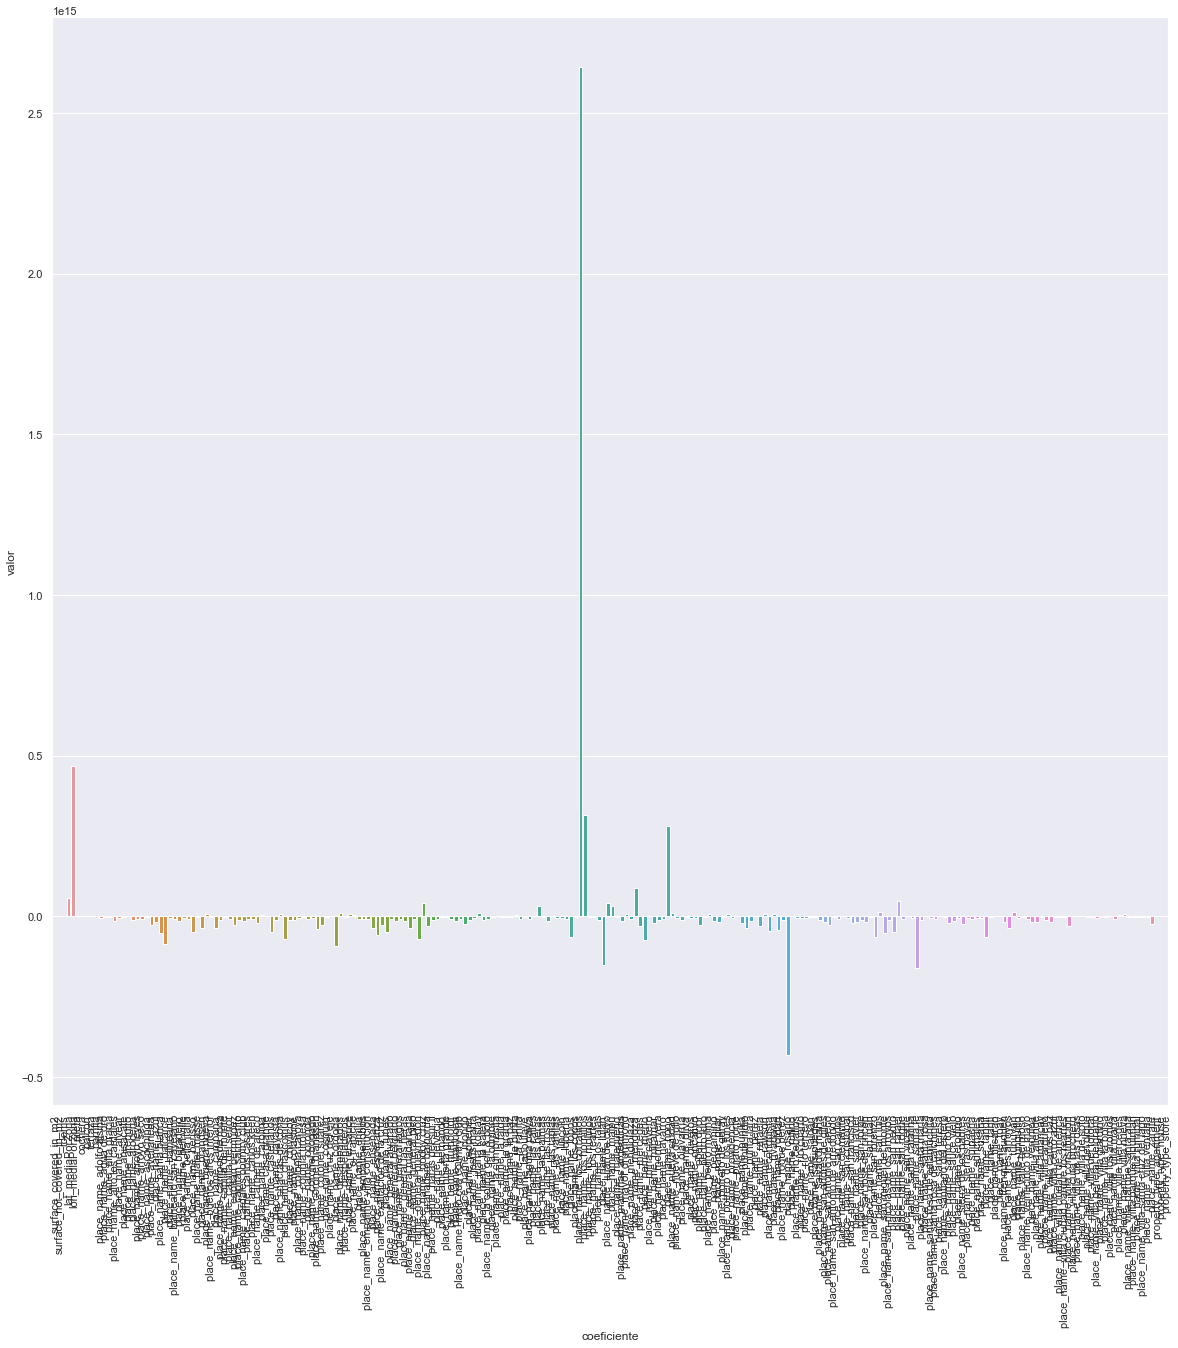

In [42]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [43]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

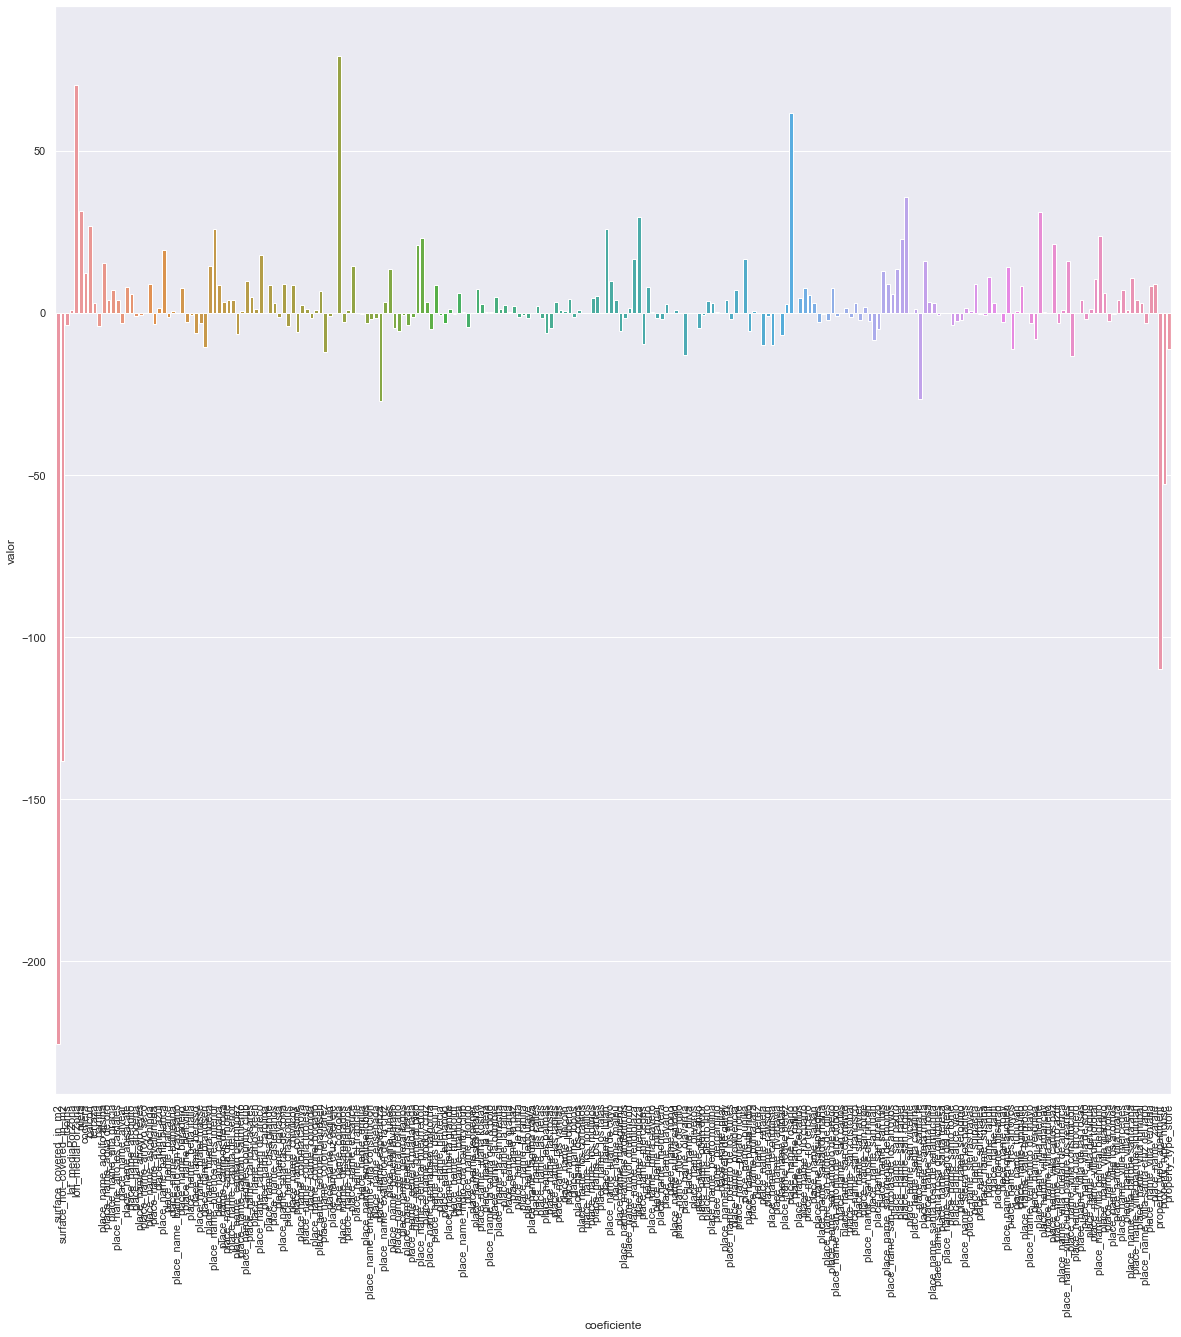

In [44]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [45]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

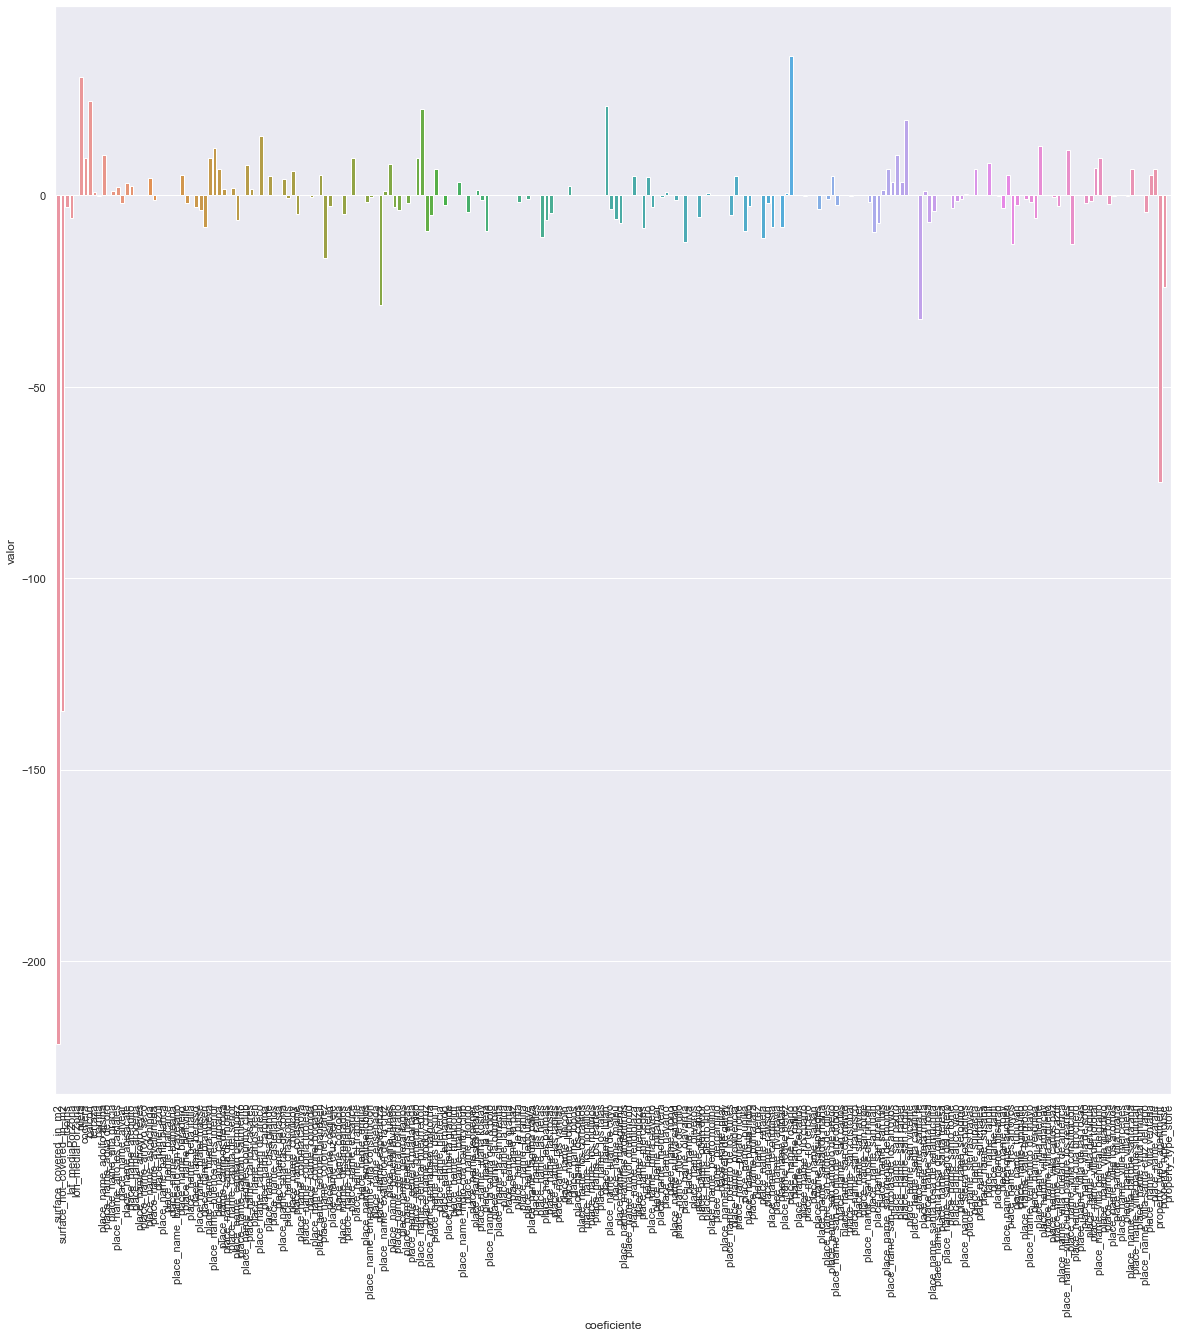

In [46]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20